In [3]:
import matplotlib.pyplot as plt
import numpy as np
import torch

import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.nn import Module, Sequential, Conv2d, ConvTranspose2d, LeakyReLU, BatchNorm2d, ReLU, Tanh, Sigmoid, BCELoss 

%matplotlib inline

ModuleNotFoundError: No module named 'torch'

In [ ]:
import os
from PIL import Image
# path to the image directory
dir_data  = "C:/Users/tjzha/OneDrive/Documents/GitHub/GAN/data/road_crop_image"
 
# setting image shape to 32x32
img_shape = (256, 256, 3)
 
# listing out all file names
nm_imgs   = np.sort(os.listdir(dir_data))
nm_imgs


In [ ]:
X_train = []
for file in nm_imgs:
    try:
        img = Image.open(dir_data+'/'+file)
        img = img.convert('RGB')
        img = img.resize((256,256))
        img = np.asarray(img)/255
        X_train.append(img)
    except:
        print("something went wrong")
 
X_train = np.array(X_train)
X_train.shape

In [ ]:
from numpy import asarray
from numpy import savez_compressed
 
# save to npy file
savez_compressed('road_images_256x256.npz', X_train)

In [ ]:
# # load dict of arrays
# dict_data = np.load('road_images_256x256.npz')
 
# # extract the first array
# data = dict_data['arr_0']
 
# # print the array
# print(data)

In [4]:
torch.cuda.is_available()

NameError: name 'torch' is not defined

In [7]:
# plot images in a nxn grid
def plot_images(imgs, grid_size = 5):
    """
    imgs: vector containing all the numpy images
    grid_size: 2x2 or 5x5 grid containing images
    """
    
    fig = plt.figure(figsize = (8, 8))
    columns = rows = grid_size
    plt.title("Training Images")

    for i in range(1, columns*rows +1):
        plt.axis("off")
        fig.add_subplot(rows, columns, i)
        plt.imshow(imgs[i])
        plt.axis("off")
    plt.show()

In [8]:
# load the numpy vector containing image representations
imgs = np.load('road_images_256x256.npz')

# to check all the files contained in it
imgs.files

# this is where all our images are saved
imgs['arr_0'].shape


(2160, 256, 256, 3)

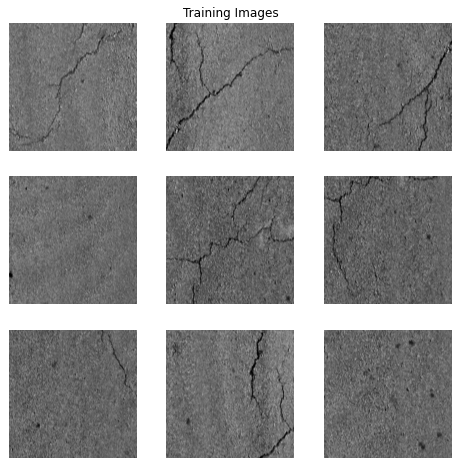

In [9]:
# pls ignore the poor quality of the images as we are working with 32x32 sized images.
plot_images(imgs['arr_0'], 3)

In [10]:
# Always good to check if gpu support available or not

dev = 'cuda:0' if torch.cuda.is_available() == True else 'cpu'
device = torch.device(dev)


In [11]:
# To check the device name
print ('Current cuda device name ', torch.cuda.get_device_name())

Current cuda device name  NVIDIA GeForce GTX 1050 Ti


In [12]:
# Preparing custom dataset class - https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class


class HumanFacesDataset(Dataset):
    """Human Faces dataset."""

    def __init__(self, npz_imgs):
        """
        Args:
            npz_imgs (string): npz file with all the images (created in gan.ipynb)
        """
        self.imgs = npz_imgs

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image = self.imgs[idx]

        return image

In [13]:
imgs['arr_0'][0].dtype # it will output float 64 i.e. double

# must convert it to float 32 (which is same as model weights)
np.float32(imgs['arr_0']).dtype

dtype('float32')

In [27]:
# Preparing dataloader for training

transpose_imgs = np.transpose( # imp step to convert image size from (7312, 32,32,3) to (7312, 3,32,32)
    np.float32(imgs['arr_0']), # imp step to convert double -> float (by default numpy input uses double as data type)
    (0, 3,1,2) # tuple to describe how to rearrange the dimensions
    ) 

dset = HumanFacesDataset(transpose_imgs) # passing the npz variable to the constructor class
batch_size = 32
shuffle = True

dataloader = DataLoader(dataset = dset, batch_size = batch_size, shuffle = shuffle)


In [1]:
transpose_imgs

NameError: name 'transpose_imgs' is not defined

In [28]:
# Defining the Generator class

class Generator(Module):
    def __init__(self):

        # calling constructor of parent class
        super().__init__()

        self.gen = Sequential(
          ConvTranspose2d(in_channels = 100, out_channels = 512 , kernel_size = 4, stride = 1, padding = 0, bias = False),
          # the output from the above will be b_size ,512, 4,4
          BatchNorm2d(num_features = 512), # From an input of size (b_size, C, H, W), pick num_features = C
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 512, out_channels = 256 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,256, 8,8
          BatchNorm2d(num_features = 256),
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 256, out_channels = 128 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,128, 16,16
          BatchNorm2d(num_features = 128),
          ReLU(inplace = True),

          ConvTranspose2d(in_channels = 1024, out_channels = 3 , kernel_size = 4, stride = 2, padding = 1, bias = False),
          # the output from the above will be b_size ,3, 32,32
          Tanh()
        
        )

    def forward(self, input):
        return self.gen(input)




In [29]:
netG = Generator().to(device)

print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [30]:
# torch.randn(2, 100,1,1).shape

In [31]:
# As an example, to show the shape of the output from the generator -  must be an image
t = torch.randn(2, 100, 1, 1)
netG(t.to(device)).shape

torch.Size([2, 3, 32, 32])

In [19]:
def init_weights(m):
    if type(m) == ConvTranspose2d:
        nn.init.normal_(m.weight, 0.0, 0.02)
    elif type(m) == BatchNorm2d:
        nn.init.normal_(m.weight, 1.0, 0.02)
        nn.init.constant_(m.bias, 0)

In [20]:
# Let's initialize the weights randomly (for a single layer)
netG.apply(init_weights)

# Print the model
print(netG)

Generator(
  (gen): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): Tanh()
  )
)


In [21]:
# Defining the Discriminator class

class Discriminator(Module):
    def __init__(self):

        super().__init__()
        self.dis = Sequential(

            # input is (3, 32, 32)
            Conv2d(in_channels = 3, out_channels = 256, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32, 16, 16
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 256, out_channels = 256*2, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*2, 8, 8
            BatchNorm2d(256 * 2),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 256*2, out_channels = 256*4, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 32*4, 4, 4
            BatchNorm2d(256 * 4),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 256*4, out_channels = 256*8, kernel_size = 4, stride = 2, padding = 1, bias=False),
            # ouput from above layer is b_size, 256, 2, 2
            # NOTE: spatial size of this layer is 2x2, hence in the final layer, the kernel size must be 2 instead (or smaller than) 4
            BatchNorm2d(256 * 8),
            LeakyReLU(0.2, inplace=True),

            Conv2d(in_channels = 256*8, out_channels = 1, kernel_size = 2, stride = 2, padding = 0, bias=False),
            # ouput from above layer is b_size, 1, 1, 1
            Sigmoid()
        )
    
    def forward(self, input):
        return self.dis(input)

In [22]:
# As an example, to show the shape of the output from the generator -  must be an integer
t = torch.randn(2, 3, 256, 256)

netD = Discriminator().to(device)
netD(t.to(device)).shape

torch.Size([2, 1, 8, 8])

In [23]:
# initializing the weights
netD.apply(init_weights)

print(netD)

Discriminator(
  (dis): Sequential(
    (0): Conv2d(3, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(2048, 1, kernel_size=(2, 2), stride=(2, 2), bias=False)
    (12): Sigmoid()
  )
)


In [24]:
# Setting up otimizers for both Generator and Discriminator

opt_D = optim.Adam(netD.parameters(), lr = 0.0002, betas= (0.5, 0.999))
opt_G = optim.Adam(netG.parameters(), lr = 0.0002, betas= (0.5, 0.999))


In [25]:
# Setting up the loss function - BCELoss (to check how far the predicted value is from real value)

loss = BCELoss()

In [26]:
# TRAINING GANS
epochs = 1000

# going over the entire dataset 10 times
for e in range(epochs):
    
    # pick each batch b of input images: shape of each batch is (32, 3, 32, 32)
    for i, b in enumerate(dataloader):

        ##########################
        ## Update Discriminator ##
        ##########################

        # Loss on real images
        
        # clear the gradient
        opt_D.zero_grad() # set the gradients to 0 at start of each loop because gradients are accumulated on subsequent backward passes
        # compute the D model output
        yhat = netD(b.to(device)).view(-1) # view(-1) reshapes a 4-d tensor of shape (2,1,1,1) to 1-d tensor with 2 values only
        # specify target labels or true labels
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_real = loss(yhat, target)
        # calculate gradients -  or rather accumulation of gradients on loss tensor
        loss_real.backward()

        # Loss on fake images

        # generate batch of fake images using G
        # Step1: creating noise to be fed as input to G
        noise = torch.randn(len(b), 100, 1, 1, device = device)
        # Step 2: feed noise to G to create a fake img (this will be reused when updating G)
        fake_img = netG(noise) 

        # compute D model output on fake images
        yhat = netD.cuda()(fake_img.detach()).view(-1) # .cuda() is essential because our input i.e. fake_img is on gpu but model isnt (runtimeError thrown); detach is imp: Basically, only track steps on your generator optimizer when training the generator, NOT the discriminator. 
        # specify target labels
        target = torch.zeros(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_fake = loss(yhat, target)
        # calculate gradients
        loss_fake.backward()

        # total error on D
        loss_disc = loss_real + loss_fake

        # Update weights of D
        opt_D.step()

        ##########################
        #### Update Generator ####
        ##########################

        # clear gradient
        opt_G.zero_grad()
        # pass fake image through D
        yhat = netD.cuda()(fake_img).view(-1)
        # specify target variables - remember G wants D *to think* these are real images so label is 1
        target = torch.ones(len(b), dtype=torch.float, device=device)
        # calculate loss
        loss_gen = loss(yhat, target)
        # calculate gradients
        loss_gen.backward()
        # update weights on G
        opt_G.step()


        ####################################
        #### Plot some Generator images ####
        ####################################

        # during every epoch, print images at every 10th iteration.
        if i% 10 == 0:
            # convert the fake images from (b_size, 3, 32, 32) to (b_size, 32, 32, 3) for plotting 
            img_plot = np.transpose(fake_img.detach().cpu(), (0,2,3,1)) # .detach().cpu() is imp for copying fake_img tensor to host memory first
            plot_images(img_plot)
            print("********************")
            print(" Epoch %d and iteration %d " % (e, i))

        
        

ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([2048])) is deprecated. Please ensure they have the same size.